In [1]:
from tp1 import MSE, Linear, Context

import os
import shutil
from pathlib import Path

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset , DataLoader
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from tensorboard.backend.event_processing import event_accumulator

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

# Optimiseur SGD

In [2]:
X = torch.randn(50, 13, requires_grad=True, dtype=torch.float32)
Y = torch.randn(50, 3, requires_grad=True, dtype=torch.float32)

W = torch.nn.Parameter(torch.randn(13,3))
b = torch.nn.Parameter(torch.randn(3))

epsilon = 0.05

optimizer = torch.optim.SGD(params=[W,b],lr=epsilon)
optimizer.zero_grad()

In [3]:
train_loss = []
NB_EPOCH = 1000

for i in range(NB_EPOCH):
    Y_hat = Linear.apply(X, W, b)
    loss = MSE.apply(Y_hat, Y)
    train_loss.append(loss.item())
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

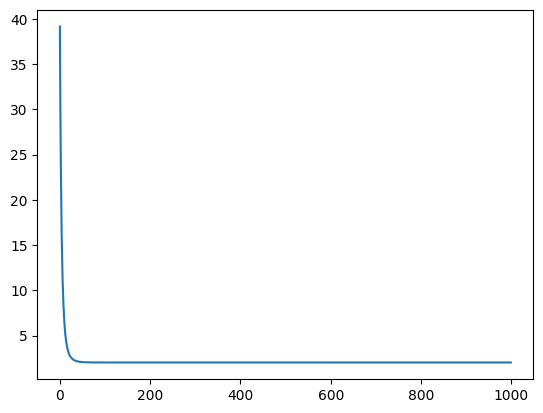

In [4]:
plt.plot(train_loss)

# Optimiseur Adam

In [5]:
X = torch.randn(50, 13, requires_grad=True, dtype=torch.float32)
Y = torch.randn(50, 3, requires_grad=True, dtype=torch.float32)

W = torch.nn.Parameter(torch.randn(13,3))
b = torch.nn.Parameter(torch.randn(3))

epsilon = 0.05

optimizer = torch.optim.Adam(params=[W,b],lr=epsilon)
optimizer.zero_grad()

In [6]:
train_loss = []
NB_EPOCH = 1000

for i in range(NB_EPOCH):
    Y_hat = Linear.apply(X, W, b)
    loss = MSE.apply(Y_hat, Y)
    train_loss.append(loss.item())
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

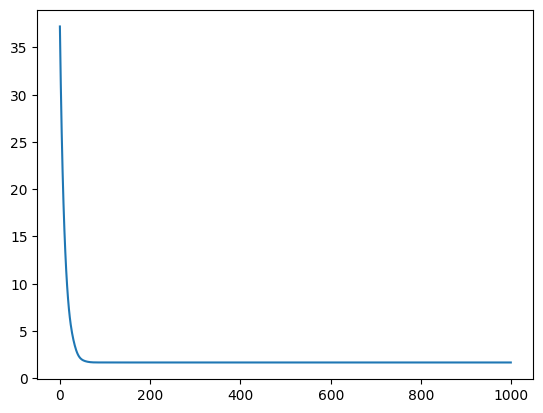

In [7]:
plt.plot(train_loss)

# Reseau de neurones manuel

In [8]:
mse=torch.nn.MSELoss()
tanh = torch.nn.Tanh()
linear=torch.nn.Linear(13,100)
linear2=torch.nn.Linear(100,3)

epsilon = 0.05

train_loss = []

# Données
X = torch.randn(50, 13, requires_grad=True, dtype=torch.float32)
Y = torch.randn(50, 3, requires_grad=True, dtype=torch.float32)

# Fonction de perte et optimiseur
loss_fn = nn.MSELoss()
optimizer = optim.SGD(list(linear.parameters()) + list(linear2.parameters()), lr=epsilon)

In [9]:
train_loss = []
NB_EPOCH = 1000

for i in range(NB_EPOCH):
    pred = linear2(tanh(linear(X)))
    loss = loss_fn(pred, Y)
    train_loss.append(loss.item())
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

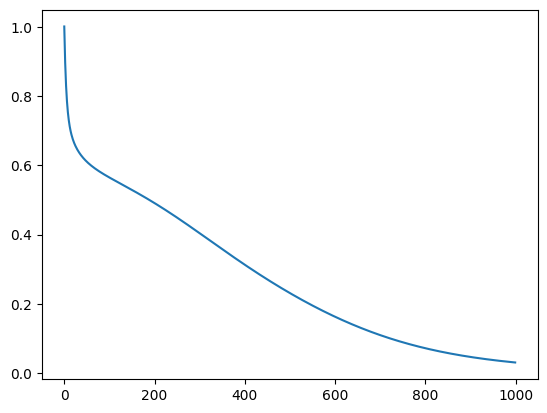

In [10]:
plt.plot(train_loss)

# Réseau de neurones semi-auto

In [11]:
linear_tanh_stack = nn.Sequential(
            nn.Linear(13, 100),
            nn.Tanh(),
            nn.Linear(100, 3),
        )

epsilon = 0.05

train_loss = []

# Données
X = torch.randn(50, 13, requires_grad=True, dtype=torch.float32)
Y = torch.randn(50, 3, requires_grad=True, dtype=torch.float32)

# Fonction de perte et optimiseur
loss_fn = nn.MSELoss()
optimizer = optim.SGD(linear_tanh_stack.parameters(), lr=epsilon)

In [12]:
train_loss = []
NB_EPOCH = 1000

for i in range(NB_EPOCH):
    pred = linear_tanh_stack(X)
    loss = loss_fn(pred, Y)
    train_loss.append(loss.item())
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

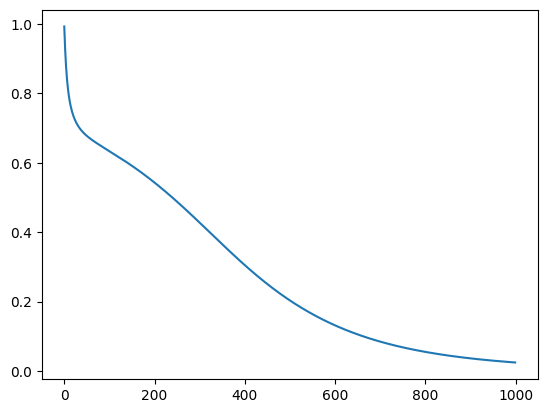

In [13]:
plt.plot(train_loss)

# Reseau de neurones

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        w = torch.nn.Parameter(torch.randn(13,3))
        b = torch.nn.Parameter(torch.randn(3))

        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(13, 100),
            nn.Tanh(),
            nn.Linear(100, 3),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [15]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=13, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=3, bias=True)
  )
)


In [16]:
model = NeuralNetwork()

epsilon = 0.05

train_loss = []

# Données
X = torch.randn(50, 13, requires_grad=True, dtype=torch.float32)
Y = torch.randn(50, 3, requires_grad=True, dtype=torch.float32)

# Fonction de perte et optimiseur
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=epsilon)

In [17]:
train_loss = []
NB_EPOCH = 1000

model.train()
for i in range(NB_EPOCH):
    pred = model(X)
    loss = loss_fn(pred, Y)
    train_loss.append(loss.item())
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

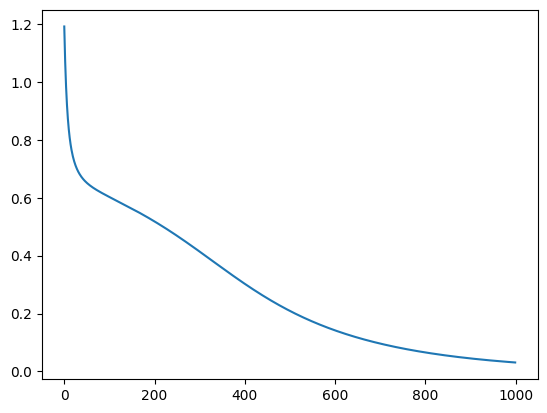

In [18]:
plt.plot(train_loss)

# Dataset

In [19]:
path = "D:\\amal\\dataset"
x , y = fetch_openml ("mnist_784",return_X_y=True , as_frame=False , data_home=path)

In [20]:
x.shape, y.shape

((70000, 784), (70000,))

In [21]:
# séparation train set, test set
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0)

In [22]:
class MonDataset(Dataset):
    def __init__(self, X, y):
        scaler = MinMaxScaler()
        self.X = torch.tensor(scaler.fit_transform(X.astype(np.float32)),
                              dtype=torch.float32)
        self.y = torch.tensor(y.astype(int), dtype=torch.long)
        self.Xshape = X.shape
        self.yshape = y.shape
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.Xshape[0]
    
train_dataset = MonDataset(X_train, y_train)
data_train = DataLoader(train_dataset, shuffle=True, batch_size=32)

test_dataset = MonDataset(X_test, y_test)
data_test = DataLoader(test_dataset, shuffle=True, batch_size=32)

In [23]:
i = 0
for batch_X, batch_y in data_train:
    if i == 0:
        print(batch_X.shape)
        print(batch_y.shape)
    i += 1
print(i)

torch.Size([32, 784])
torch.Size([32])
1750


In [24]:
train_dataset[0][0].shape, train_dataset[0][1]

(torch.Size([784]), tensor(4))

In [25]:
len(train_dataset), len(test_dataset)

(56000, 14000)

In [26]:
len(train_dataset) // 32, len(test_dataset) // 32

(1750, 437)

In [27]:
i = 0
for batch_X, batch_y in data_test:
    if i == 0:
        print(batch_X.shape)
        print(batch_y.shape)
    i += 1
print(i)

torch.Size([32, 784])
torch.Size([32])
438


# CUDA

In [52]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

if device == "cuda":
    print(f"GPU : {torch.cuda.get_device_name()}")

Using cuda device
GPU : NVIDIA GeForce RTX 3050


In [29]:
class MonDataset(Dataset):
    def __init__(self, X, y):
        scaler = MinMaxScaler()
        self.X = torch.tensor(scaler.fit_transform(X.astype(np.float32)),
                              dtype=torch.float32).to(device)
        self.y = torch.tensor(y.astype(int), dtype=torch.long).to(device)
        self.Xshape = X.shape
        self.yshape = y.shape
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.Xshape[0]

model = model.to(device)     

path = "D:\\amal\\dataset"
x , y = fetch_openml ("mnist_784",return_X_y=True , as_frame=False , data_home=path)

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0)

train_dataset = MonDataset(X_train, y_train)
data_train = DataLoader(train_dataset, shuffle=True, batch_size=32)

test_dataset = MonDataset(X_test, y_test)
data_test = DataLoader(test_dataset, shuffle=True, batch_size=32)

In [30]:
# Devrait afficher "cuda:0" si les données sont sur le GPU

for param in model.parameters():
    print(param.device)

cuda:0
cuda:0
cuda:0
cuda:0


In [31]:
# Devrait afficher "cuda:0" si les données sont sur le GPU

for batch_X, batch_y in data_train:
    print(batch_X.device)
    print(batch_y.device)
    break

cuda:0
cuda:0


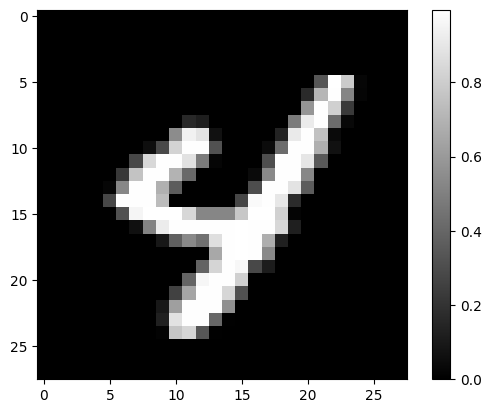

label: 4


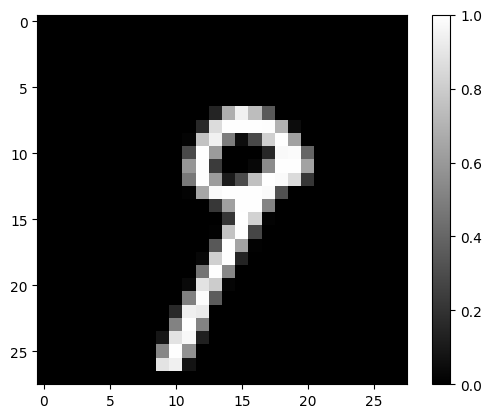

label: 9


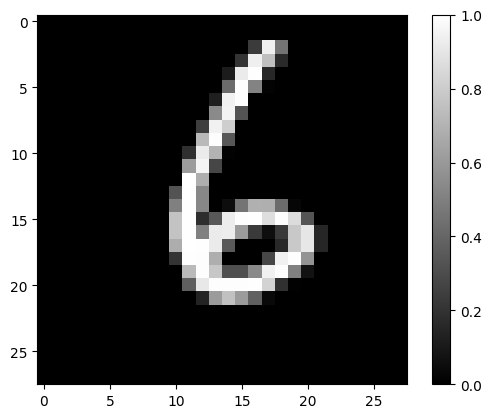

label: 6


In [32]:
for i in range(3):
    
    image, label = train_dataset[i]

    image_tensor = image.view(28, 28)

    plt.imshow(image_tensor.cpu().detach().numpy(), cmap='gray')
    plt.colorbar()  # Optionnel pour montrer la barre de couleur
    plt.show()

    print(f"label: {label}")

# Checkpointing

In [33]:
savepath = Path("model.pch")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
class State:
    def __init__(self, model, optimizer, checkpoint_dir):
        self.model = model
        self.optimizer = optimizer
        self.epoch = 0
        self.checkpoint_dir = checkpoint_dir

    def save_checkpoint(self, epoch):
        checkpoint_path = os.path.join(self.checkpoint_dir, f'checkpoint_epoch_{epoch}.pt')
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

    def load_checkpoint(self):
        # Trouver les checkpoints dans le répertoire
        checkpoints = [f for f in os.listdir(self.checkpoint_dir) if f.startswith('checkpoint_epoch_')]
        if not checkpoints:
            print("Aucun checkpoint trouvé.")
            return False

        # Tri pour prendre le dernier checkpoint par numéro d'epoch
        latest_checkpoint = max(checkpoints, key=lambda f: int(f.split('_')[2].split('.')[0]))
        checkpoint_path = os.path.join(self.checkpoint_dir, latest_checkpoint)

        print(f"Chargement du checkpoint : {latest_checkpoint}")
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epoch = checkpoint['epoch']

        return True

# Autoencodeur

In [35]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_space_size):
        super().__init__()
        
        #encoder
        self.encoder = nn.Linear(input_size, latent_space_size)
        self.relu = nn.ReLU()
        
        # decoder
        self.decoder = nn.Linear(latent_space_size, input_size)
        self.sigmoid = nn.Sigmoid()
        
        self.decoder.weight.data.copy_(self.encoder.weight.data.T.clone())
        
    def forward(self, x):
        z = self.encoder(x)
        z = self.relu(z)
        
        output = self.decoder(z)
        output = self.sigmoid(output)
        
        return output

# Training

In [182]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 784
latent_space_size = 64

model = Autoencoder(input_size, latent_space_size).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [185]:
num_epochs = 20

# Récupérer l'emplacement du fichier
script_dir = os.getcwd()
runs_dir = os.path.join(script_dir, "run_autoencoder1")

# Créer le dossier 'runs'
os.makedirs(runs_dir, exist_ok=True)

# Définit le SummaryWriter
log_dir = os.path.join(script_dir, "loss_autoencoder1")
os.makedirs(log_dir, exist_ok=True)
logger = SummaryWriter(os.path.join(log_dir))

# Initialisation de l'état
state = State(model, optimizer, runs_dir)

# Chargement du dernier checkpoint s'il existe
checkpoint_loaded = state.load_checkpoint()

# Déterminer le point de départ de l'entraînement
start_epoch = state.epoch if checkpoint_loaded else 0

# Boucle d'entraînement
for epoch in tqdm(range(start_epoch, start_epoch + num_epochs)):
    
    #training loop
    cumloss = 0
    for batch_X, _ in data_train:
        X_pred = state.model(batch_X)
        loss = loss_fn(X_pred, batch_X)
        cumloss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = cumloss / 1750  # 1750 batches
    logger.add_scalar("trainloss", avg_loss, epoch)
    
    #testing loop
    test_loss = 0
    with torch.no_grad():
        for batch_X, _ in data_test:
            X_pred = state.model(batch_X)
            loss = loss_fn(X_pred, batch_X)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / 438 # 438 batches
    logger.add_scalar("testloss", avg_test_loss, epoch)

    # Sauvegarder le checkpoint tous les 10 epochs
    if (epoch + 1) % 10 == 0:
        state.save_checkpoint(epoch + 1)

C:\Users\asola\AppData\Local\Temp\ipykernel_13480\565456545.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Chargement du checkpoint : checkpoint_epoch_20.pt


 50%|█████     | 10/20 [00:29<00:29,  2.96s/it]

Checkpoint saved at epoch 30


100%|██████████| 20/20 [00:58<00:00,  2.93s/it]

Checkpoint saved at epoch 40


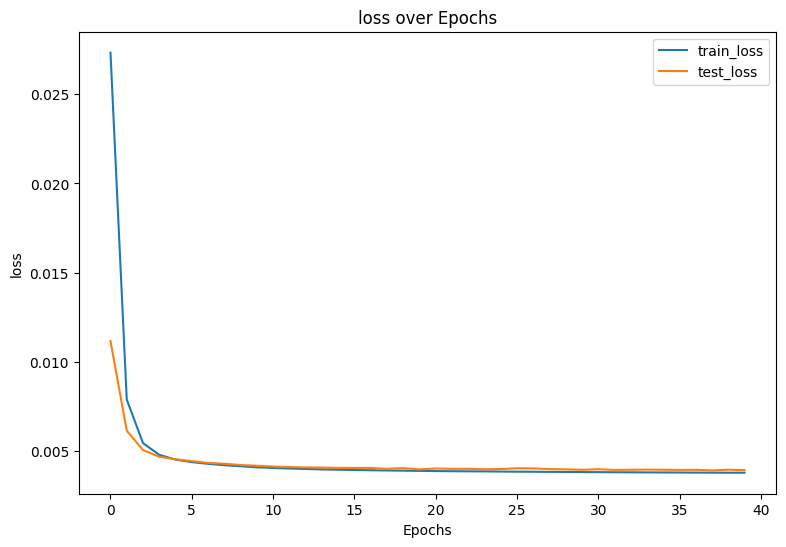

In [186]:
cript_dir = os.getcwd() 
runs_dir = os.path.join(script_dir, "loss_autoencoder1")

ea = event_accumulator.EventAccumulator(runs_dir)
ea.Reload()

# Récupére les valeurs de train_loss
values1 = ea.Scalars("trainloss")

# Extraire les itérations et les valeurs de f(beta)
epochs = [entry.step for entry in values1]
train_loss = [entry.value for entry in values1]

# Récupére les valeurs de test_loss
values2 = ea.Scalars("testloss")

epochs2 = [entry.step for entry in values2]
test_loss = [entry.value for entry in values2]

# plot
plt.figure(figsize=(9, 6))
plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs2, test_loss, label="test_loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('loss over Epochs')
plt.legend()
plt.show()

# 2eme autoencoder

In [102]:
class AutoencoderV2(nn.Module):
    def __init__(self, input_size, latent_space_size):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 424),
            nn.ReLU(),
            nn.Linear(424, latent_space_size),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_space_size, 424),
            nn.Sigmoid(),
            nn.Linear(424, input_size),
            nn.Sigmoid(),
        )
        
        self.decoder[0].weight.data.copy_(self.encoder[2].weight.data.T.clone())
        self.decoder[2].weight.data.copy_(self.encoder[0].weight.data.T.clone())
        
        
    def forward(self, x):
        z = self.encoder(x)
        
        output = self.decoder(z)
        
        return output
    
    def get_latent_space(self, x):
        
        return self.encoder(x)
    
    def get_image_from_latent(self, z):
        
        return self.decoder(z)

In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 784
latent_space_size = 64

model = AutoencoderV2(input_size, latent_space_size).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [117]:
num_epochs = 20

# Récupérer l'emplacement du fichier
script_dir = os.getcwd()
runs_dir = os.path.join(script_dir, "run_autoencoder2")

# Créer le dossier 'runs'
os.makedirs(runs_dir, exist_ok=True)

# Définit le SummaryWriter
log_dir = os.path.join(script_dir, "loss_autoencoder2")
os.makedirs(log_dir, exist_ok=True)
logger = SummaryWriter(os.path.join(log_dir))

# Initialisation de l'état
state = State(model, optimizer, runs_dir)

# Chargement du dernier checkpoint s'il existe
checkpoint_loaded = state.load_checkpoint()

# Déterminer le point de départ de l'entraînement
start_epoch = state.epoch if checkpoint_loaded else 0

# Boucle d'entraînement
for epoch in tqdm(range(start_epoch, start_epoch + num_epochs)):
    
    #training loop
    cumloss = 0
    for batch_X, _ in data_train:
        X_pred = state.model(batch_X)
        loss = loss_fn(X_pred, batch_X)
        cumloss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = cumloss / 1750  # 1750 batches
    logger.add_scalar("trainloss", avg_loss, epoch)
    
    #testing loop
    test_loss = 0
    with torch.no_grad():
        for batch_X, _ in data_test:
            X_pred = state.model(batch_X)
            loss = loss_fn(X_pred, batch_X)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / 438 # 438 batches
    logger.add_scalar("testloss", avg_test_loss, epoch)
    
    if epoch <= 6:
        image_test, _ = test_dataset[0]
        image_test_pred = state.model(image_test)
        logger.add_image("Reconstructions", image_test_pred.view(1, 28, 28), epoch)
        logger.add_image("Originals", image_test.view(1, 28, 28), epoch)

    # Sauvegarder le checkpoint tous les 10 epochs
    if (epoch + 1) % 10 == 0:
        state.save_checkpoint(epoch + 1)

C:\Users\asola\AppData\Local\Temp\ipykernel_11836\565456545.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Chargement du checkpoint : checkpoint_epoch_20.pt


 50%|█████     | 10/20 [00:37<00:36,  3.67s/it]

Checkpoint saved at epoch 30


100%|██████████| 20/20 [01:14<00:00,  3.72s/it]

Checkpoint saved at epoch 40


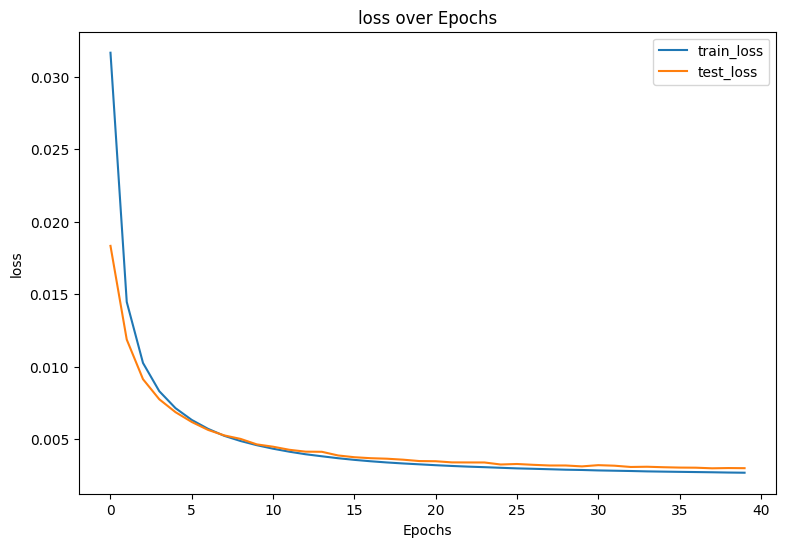

In [118]:
cript_dir = os.getcwd() 
runs_dir = os.path.join(script_dir, "loss_autoencoder2")

ea = event_accumulator.EventAccumulator(runs_dir)
ea.Reload()

# Récupére les valeurs de train_loss
values1 = ea.Scalars("trainloss")

# Extraire les itérations et les valeurs de f(beta)
epochs = [entry.step for entry in values1]
train_loss = [entry.value for entry in values1]

# Récupére les valeurs de test_loss
values2 = ea.Scalars("testloss")

epochs2 = [entry.step for entry in values2]
test_loss = [entry.value for entry in values2]

# plot
plt.figure(figsize=(9, 6))
plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs2, test_loss, label="test_loss")
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('loss over Epochs')
plt.legend()
plt.show()

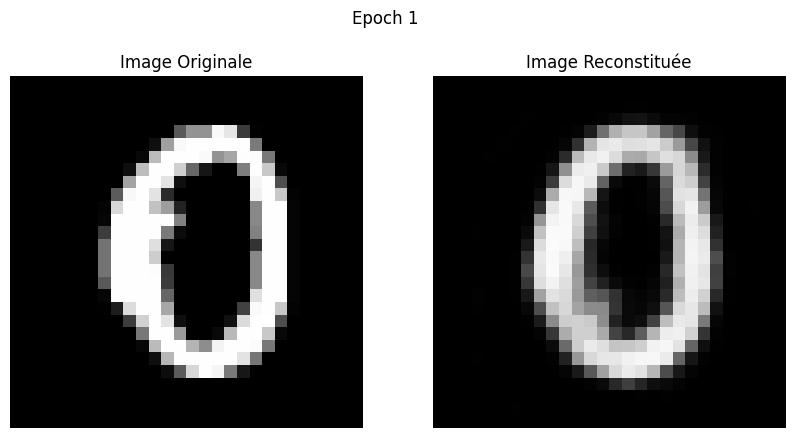

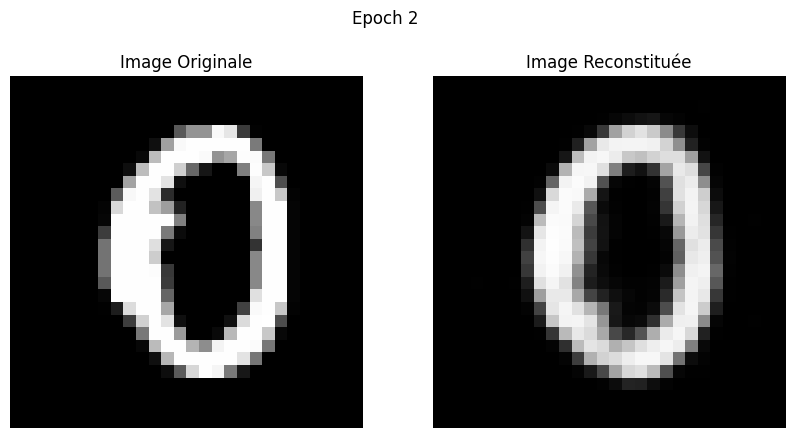

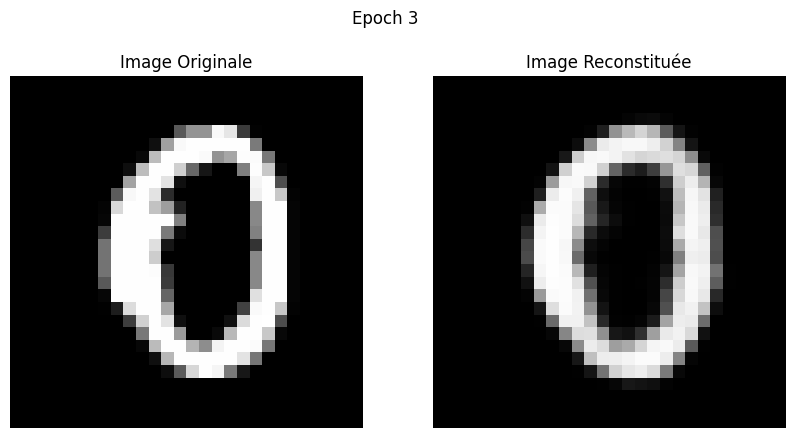

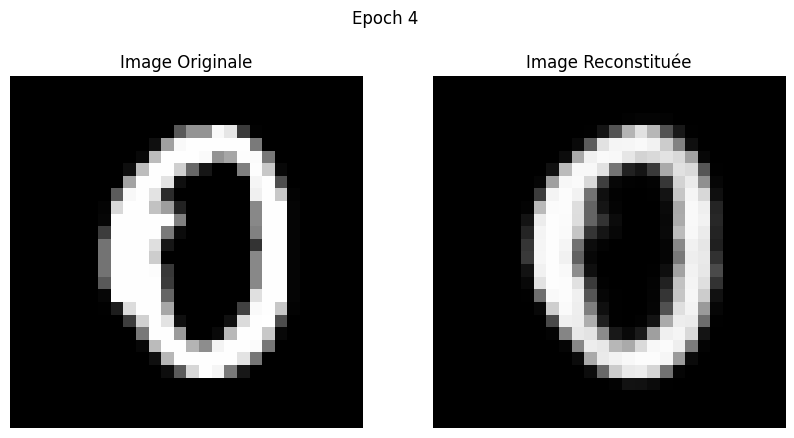

In [119]:
import io
from PIL import Image

cript_dir = os.getcwd() 
runs_dir = os.path.join(script_dir, "loss_autoencoder2")

ea = event_accumulator.EventAccumulator(runs_dir)
ea.Reload()

reconstructions = ea.Images("Reconstructions")
originals = ea.Images("Originals")

for i in range(len(reconstructions)):
    image_originale = Image.open(io.BytesIO(originals[i].encoded_image_string))
    image_reconstituée = Image.open(io.BytesIO(reconstructions[i].encoded_image_string))

    # Création de la figure avec 2 sous-graphes
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Affichage de l'image originale
    axs[0].imshow(image_originale, cmap='gray')
    axs[0].set_title("Image Originale")
    axs[0].axis('off')  # Masquer les axes

    # Affichage de l'image reconstituée
    axs[1].imshow(image_reconstituée, cmap='gray')
    axs[1].set_title("Image Reconstituée")
    axs[1].axis('off')  # Masquer les axes

    # Titre général pour le plot
    plt.suptitle(f"Epoch {i+1}")

    plt.show()

# Evalutation du modèle sur train et test set

Chargement du checkpoint : checkpoint_epoch_40.pt


C:\Users\asola\AppData\Local\Temp\ipykernel_11836\565456545.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


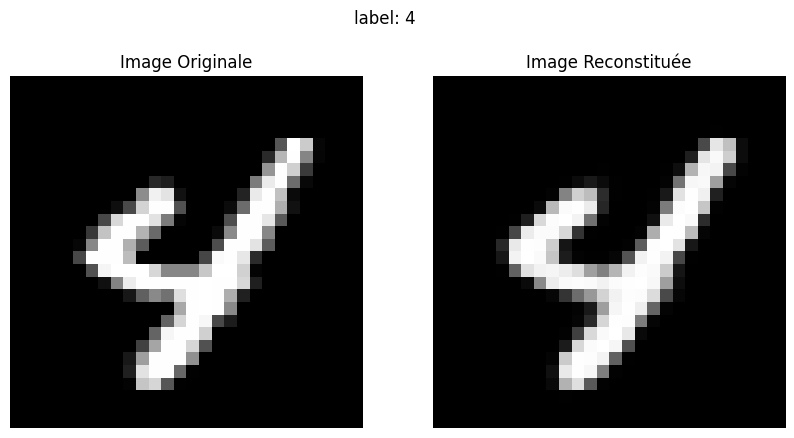

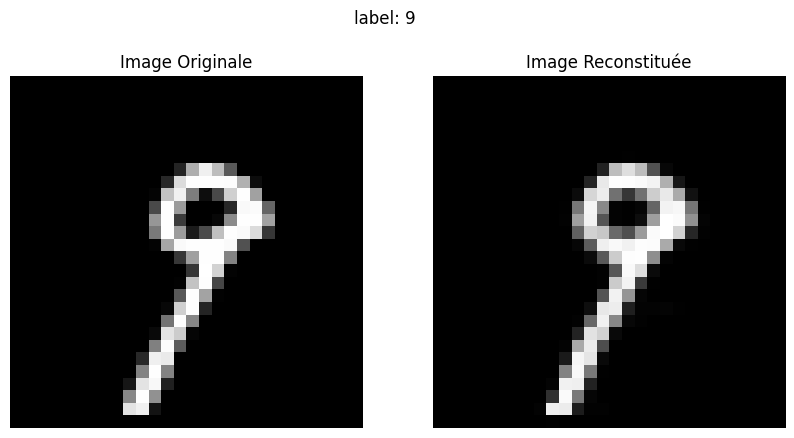

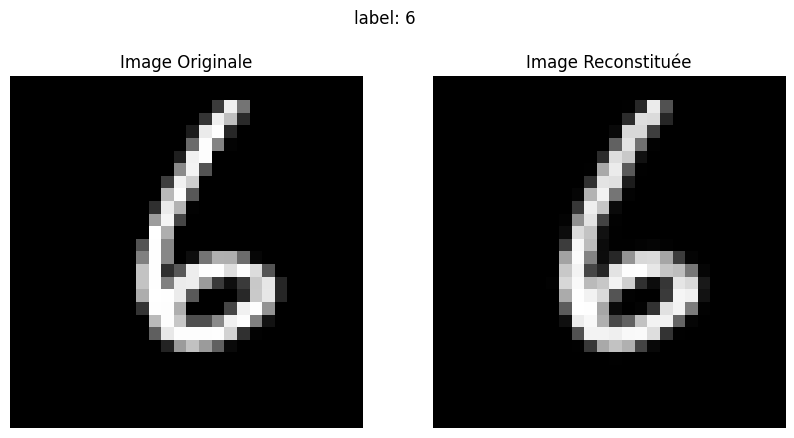

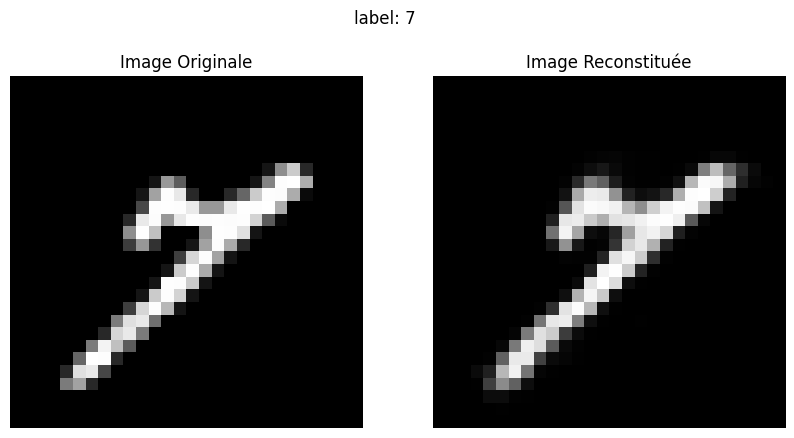

In [120]:
script_dir = os.getcwd()
runs_dir = os.path.join(script_dir, "run_autoencoder2")

# Initialisation de l'état
state = State(model, optimizer, runs_dir)

# Chargement du dernier checkpoint s'il existe
checkpoint_loaded = state.load_checkpoint()

for i in range(4):
    image, label = train_dataset[i]

    # Préparation de l'image originale
    image_tensor = image.view(28, 28)

    # Prédiction de l'image reconstituée
    image_prediction = state.model(image)
    image_tensor2 = image_prediction.view(28, 28)

    # Création de la figure avec 2 sous-graphes
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Affichage de l'image originale
    axs[0].imshow(image_tensor.cpu().detach().numpy(), cmap='gray')
    axs[0].set_title("Image Originale")
    axs[0].axis('off')  # Masquer les axes

    # Affichage de l'image reconstituée
    axs[1].imshow(image_tensor2.cpu().detach().numpy(), cmap='gray')
    axs[1].set_title("Image Reconstituée")
    axs[1].axis('off')  # Masquer les axes

    # Titre général pour le plot
    plt.suptitle(f"label: {label}")

    plt.show()

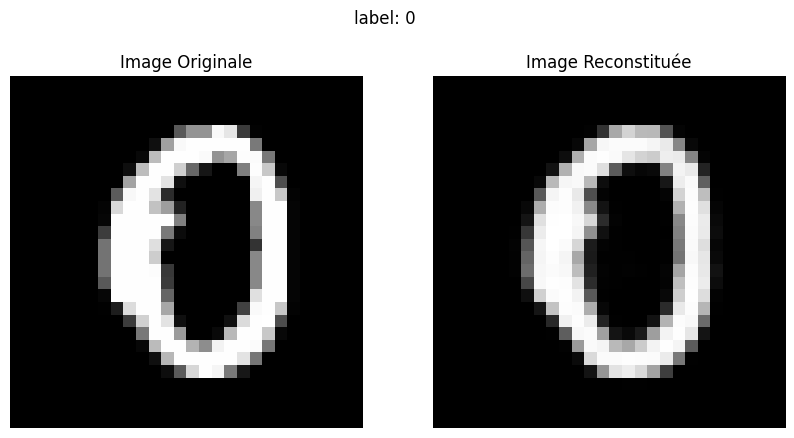

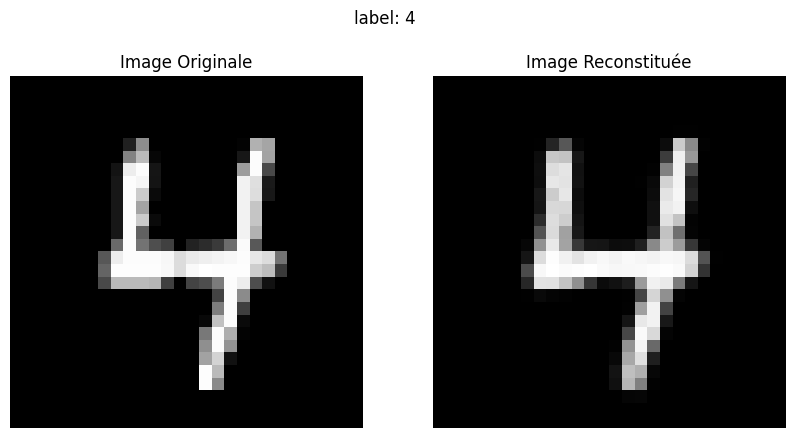

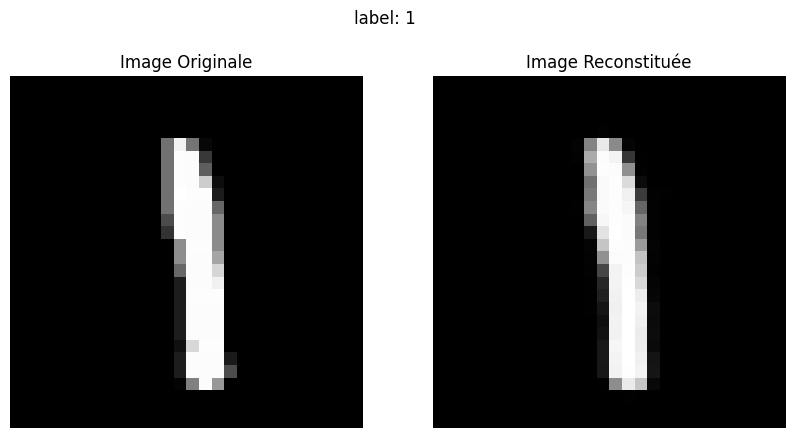

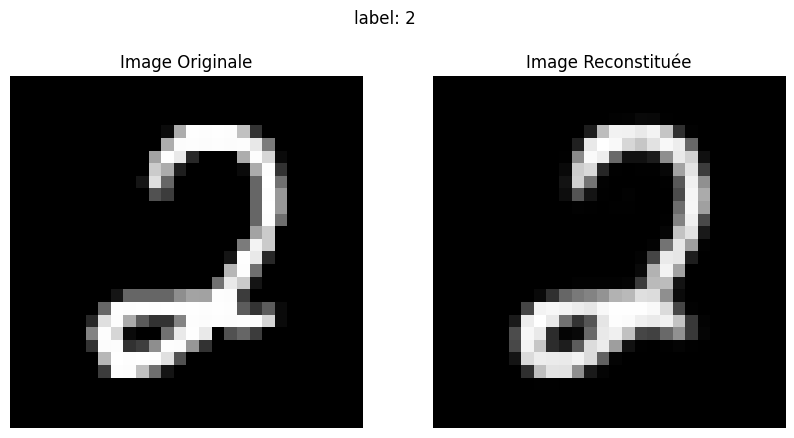

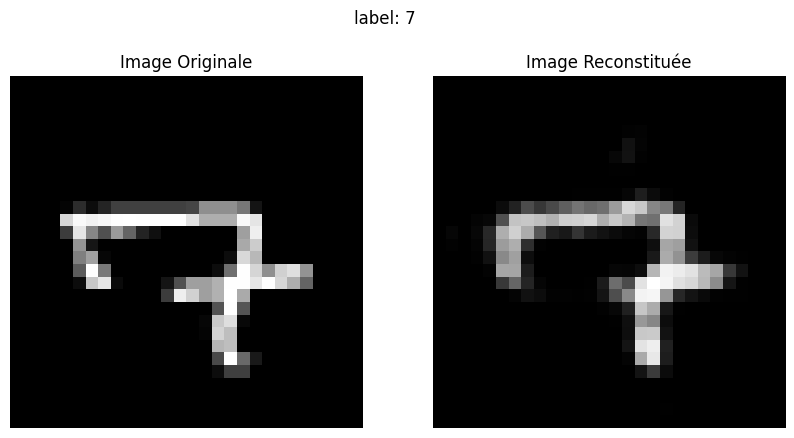

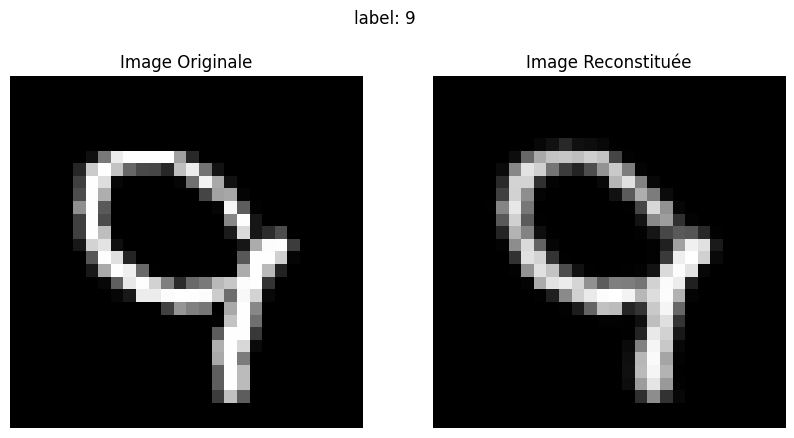

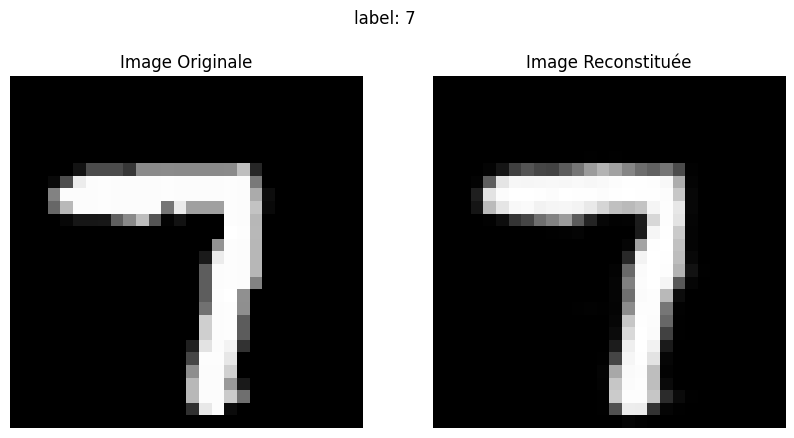

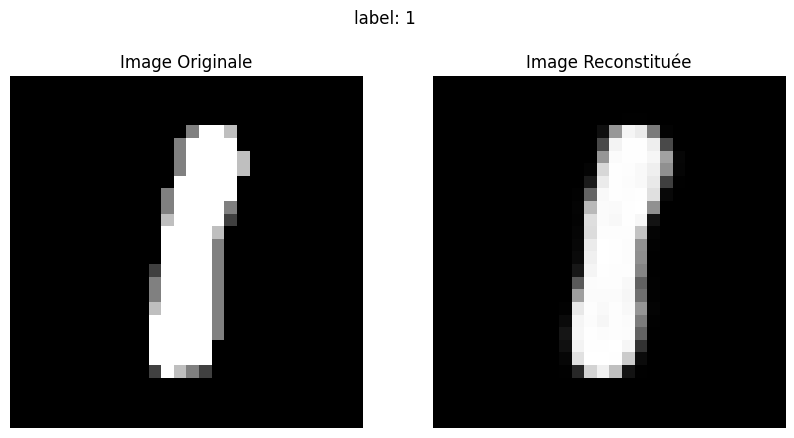

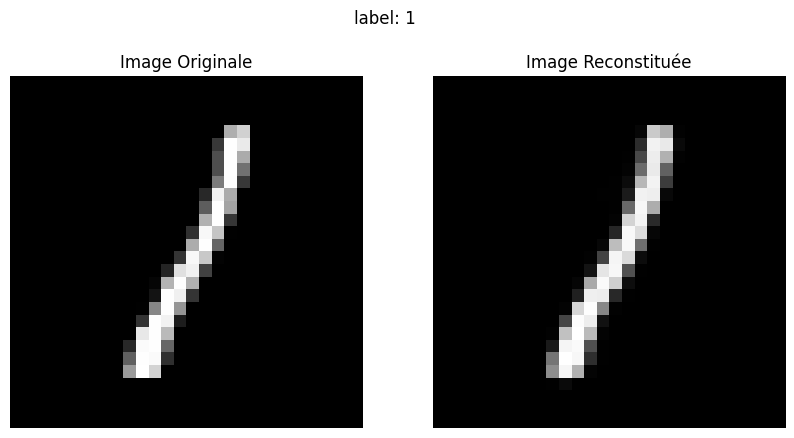

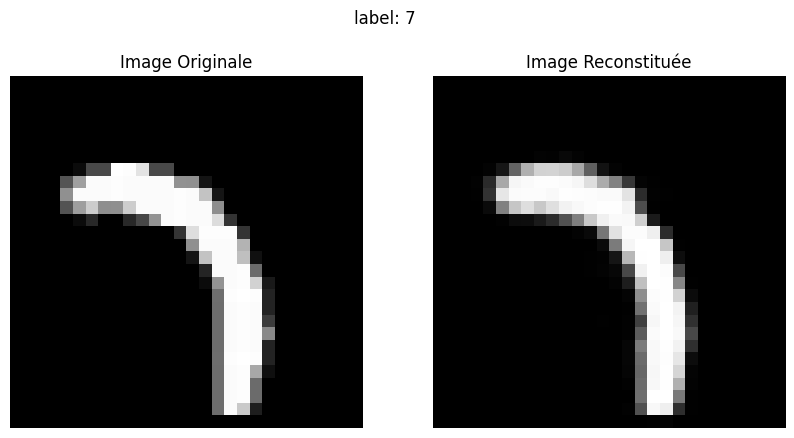

In [121]:
for i in range(10):
    image, label = test_dataset[i]

    # Préparation de l'image originale
    image_tensor = image.view(28, 28)

    # Prédiction de l'image reconstituée
    image_prediction = state.model(image)
    image_tensor2 = image_prediction.view(28, 28)

    # Création de la figure avec 2 sous-graphes
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Affichage de l'image originale
    axs[0].imshow(image_tensor.cpu().detach().numpy(), cmap='gray')
    axs[0].set_title("Image Originale")
    axs[0].axis('off')  # Masquer les axes

    # Affichage de l'image reconstituée
    axs[1].imshow(image_tensor2.cpu().detach().numpy(), cmap='gray')
    axs[1].set_title("Image Reconstituée")
    axs[1].axis('off')  # Masquer les axes

    # Titre général pour le plot
    plt.suptitle(f"label: {label}")

    plt.show()

# Interpolation sur l'espace latent

### On va réaliser l'interpolation entre ces 2 images

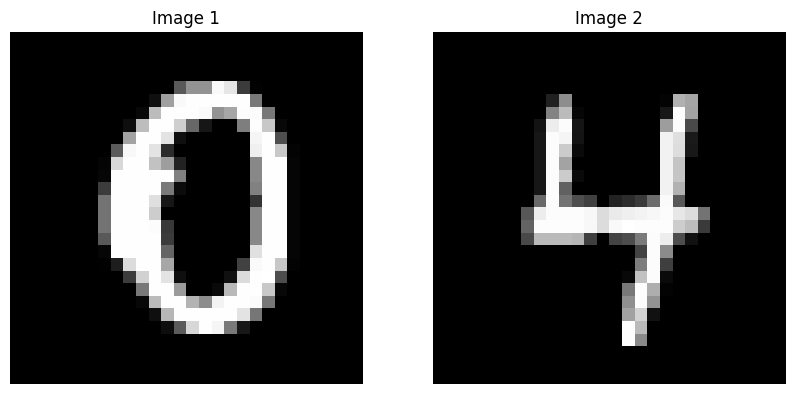

In [122]:
image1, label1 = test_dataset[0]
image2, label2 = test_dataset[1]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image1.view(28,28).cpu().detach().numpy(), cmap='gray')
axs[0].set_title("Image 1")
axs[0].axis('off')  # Masquer les axes

# Affichage de l'image reconstituée
axs[1].imshow(image2.view(28,28).cpu().detach().numpy(), cmap='gray')
axs[1].set_title("Image 2")
axs[1].axis('off')  # Masquer les axes

plt.show()

### chargement du modèle

In [124]:
script_dir = os.getcwd()
runs_dir = os.path.join(script_dir, "run_autoencoder2")

# Initialisation de l'état
state = State(model, optimizer, runs_dir)

# Chargement du dernier checkpoint s'il existe
checkpoint_loaded = state.load_checkpoint()

Chargement du checkpoint : checkpoint_epoch_40.pt


C:\Users\asola\AppData\Local\Temp\ipykernel_11836\565456545.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


### Récupération des espaces latents de image1 et image2

In [127]:
z1 = model.get_latent_space(image1)
z2 = model.get_latent_space(image2)

### On récupère 10 valeurs entre les 2 points de l'espaces latent

In [139]:
Lambdas = np.linspace(0,1,10)
z = [Lambda * z1 + (1-Lambda) * z2 for Lambda in Lambdas]

### On récupère les images associées aux points de l'espace latent

In [140]:
images = [model.get_image_from_latent(element) for element in z]

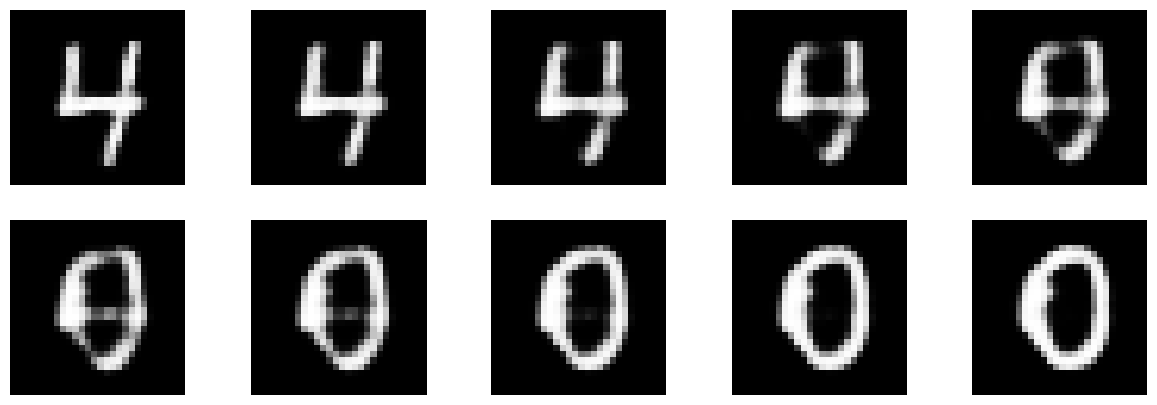

In [149]:
fig, axs = plt.subplots(2, 5, figsize=(15, 5))

for i in range(5):
    axs[0][i].imshow(images[i].view(28,28).cpu().detach().numpy(), cmap='gray')
    axs[0][i].axis('off')  # Masquer les axes
for i in range(5,10):
    axs[1][i-5].imshow(images[i].view(28,28).cpu().detach().numpy(), cmap='gray')
    axs[1][i-5].axis('off')  # Masquer les axes